# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico IV : Aprendizaje no supervisado

# Introducción

En esta notebook haremos un análisis del dataset generado anteriormente, a través de técnicas y métodos que se corresponden con Aprendizaje no supervisado.

### Estructura
En una **primera parte** se realiza clustering (con Kmeans) y embeddings (con PCA) sobre el dataset usando todas las features originales, y se analizan los resultados.

En una **segunda parte** de esta notebook se realiza un análisis análogo pero se acota el espacio de features a las dos features correspondientes a cuestiones afectivas - las features `valence` y `lyrics_sentiment` - con el propósito de explorar la utilidad en estas features a la hora de analizar el dataset, para explorar si pueden considerarse relevantes a la hora de agrupar las canciones con algún criterio en común. Debido a los resultados obtenidos se ofrecen Trabajos Futuros, en donde en conjunto con más análisis afectivo/temático de los temas se podría mejorar los primeros intentos de desarrollar un clasificador de canciones -beyond "music genres" (if they ever existed). 

### Librerías

!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install sklearn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

In [1]:
import ast
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import warnings


client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


## Funciones Generales

In [2]:
def print_kmeans_inertia(df, cluster_range=10):
    scores = [KMeans(n_clusters=i+2).fit(df).inertia_ for i in range(cluster_range)]

    plt.plot(np.arange(2, cluster_range + 2), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")
    plt.show()
    
def get_df_songs(file_path = "./final_big.csv"):
    songs_base = pd.read_csv(file_path,sep="#")
    songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
    songs_base["artists"]=songs_base["artists"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
    audio_thing= songs_base["audio_features"].apply(lambda x: ast.literal_eval(x))
    audio_features_base = pd.DataFrame(list(audio_thing))
    audio_features = audio_features_base.columns

    df_song_base = songs_base.reset_index(drop=True)
    audio_features_base = audio_features_base.reset_index(drop=True)
    df_song_base = pd.concat([df_song_base,audio_features_base],axis=1)
    return df_song_base

def scale_df_song(df, features_columns):
    df_features = df[features_columns]
    scaler = StandardScaler()
    df_scale = scaler.fit_transform(df_features)
    df_features_scale = pd.DataFrame(df_scale, columns=features_columns)
    df_features["song_name"]= df["song_name"]
    df_features["artists"]= df["artists"]

    df_features_scale["song_name"]=df["song_name"]
    df_features_scale["artists"]= df["artists"]

    
    return df_features, df_features_scale
    
def print_Silohuette(n_clusters, cluster_labels, df_skills, title):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (n_clusters + 1) * 10])

    #cluster_labels = km.labels_

    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))    
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((title),
                 fontsize=14, fontweight='bold')

    plt.show()

    

### Dependencias y acceso a APIs

In [3]:
"""
Obtener features de audio
Obtener features de texto
Combinarlas en un DataFrame
"""
warnings.filterwarnings('ignore')
df_song_base = get_df_songs()
df_song_base.columns
features_columns = ['lyrics_sentiment', 'danceability', 'energy', 'key', 
                     'loudness', 'mode', 'speechiness', 'acousticness', 
                     'instrumentalness', 'liveness', 'valence', 'tempo']

df_features, df_features_scale = scale_df_song(df_song_base, features_columns)


X_unscaled = df_features
X_scaled = df_features_scale

## Primera parte: No supervisado sobre todas las features

### Elegir un número óptimo de clusters

En este punto buscaremos el número de clusters que queremos para correr K-means obteniendo los mejores resultados. Para esto utilizaremos dos criterios de selección:
- Primero, el "método del codo" (Elbow method). Este es una técnica (heurística) muy popular en el aprendizaje no supervisado que consiste en correr el algoritmo con diferentes cantidades __k__ de clusters, calculando para cada caso la suma de distancias cuadradas de cada punto al centro asignado para su cluster (PISTA: estos valores se pueden obtener como un atributo del clasificador luego de ajustarlo a __X_scaled__). Luego graficamos para cada __k__ el valor obtenido, esto nos dará un gráfico con forma de brazo (curva) en el cual el codo del mismo (el punto de inflexión de la curva) es un buen valor para __k__.
- Segundo, el [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) nos da un coeficiente que va de -1 (peor) a 1 (mejor) y que nos dice qué tan similar es un punto a los demás dentro de su cluster y qué tan diferente es de los puntos en el resto de los clusters. En este caso nos quedaremos con el valor de k que maximice el Silhouette score para __X_scaled__.

La tarea consiste en obtener para cada caso el k que de mejores resultados de acuerdo a los gráficos obtenidos.

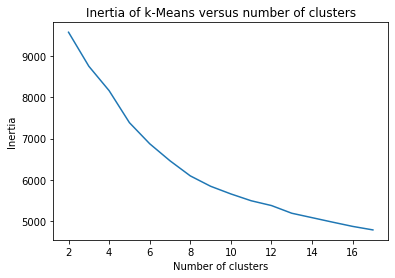

In [4]:
print_kmeans_inertia(X_scaled.drop(['artists','song_name'], axis=1), cluster_range=16)

Siguiendo el método del codo, vemos un punto de inflexión aproximado entre n_clusters 3,4, 6, 8. Avanzamos en el análisis de n_clusters con Siluetas.

<IPython.core.display.Javascript object>


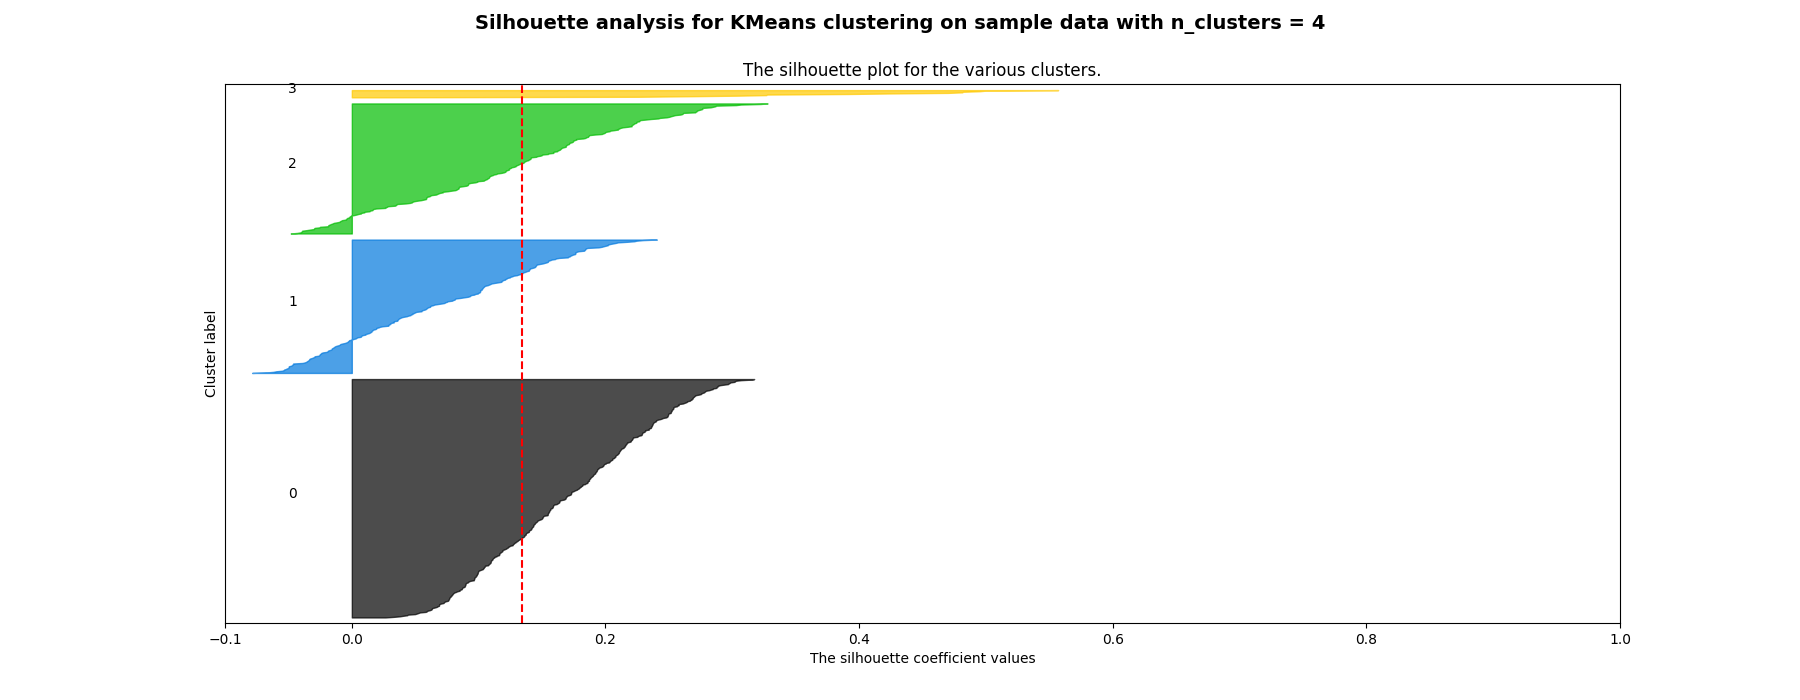

For n_clusters = 4 The average silhouette_score is : 0.13413146807236614


<IPython.core.display.Javascript object>


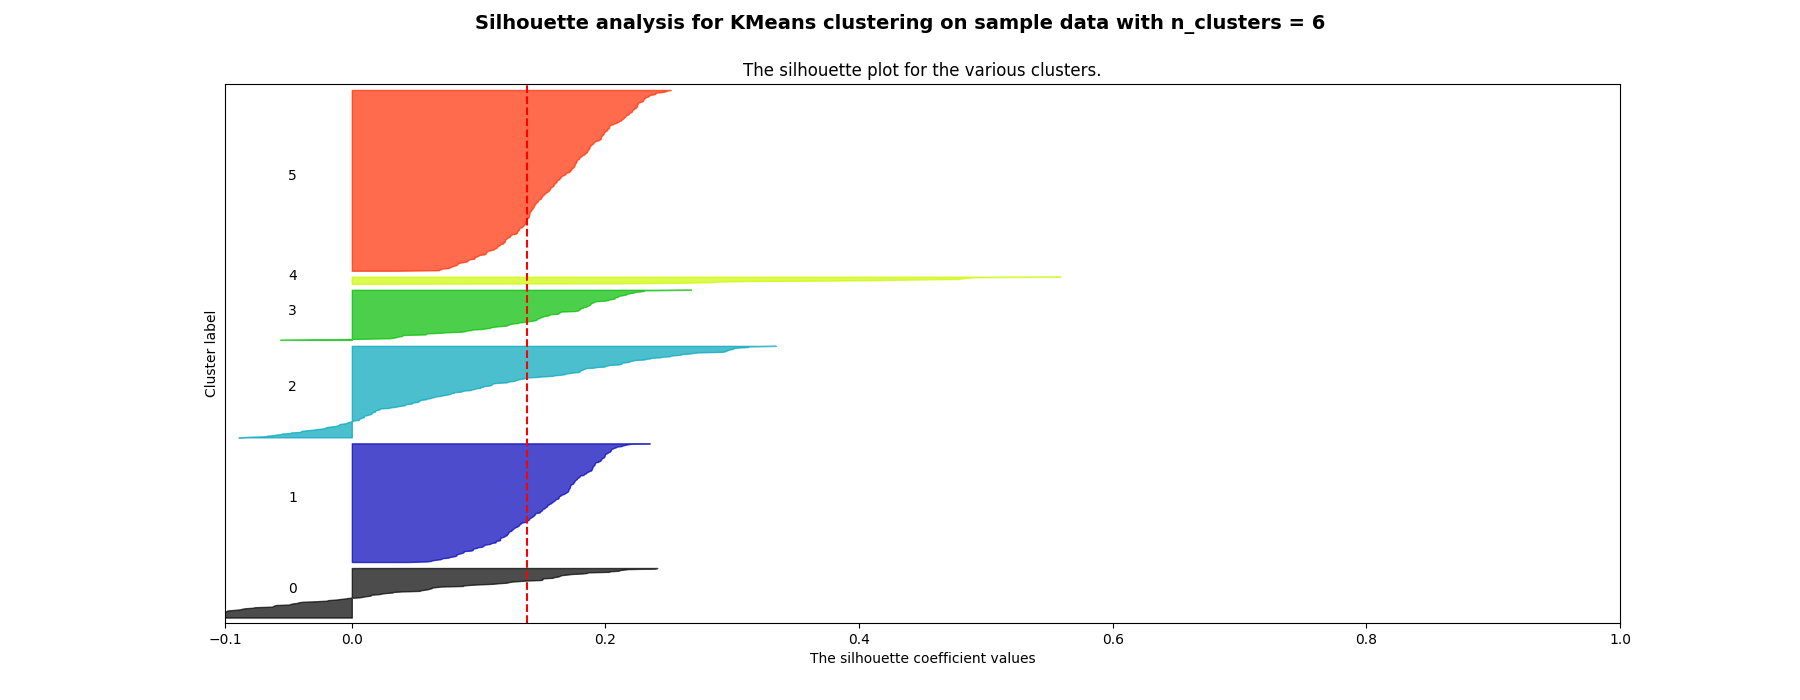

For n_clusters = 6 The average silhouette_score is : 0.13819261033199995


<IPython.core.display.Javascript object>


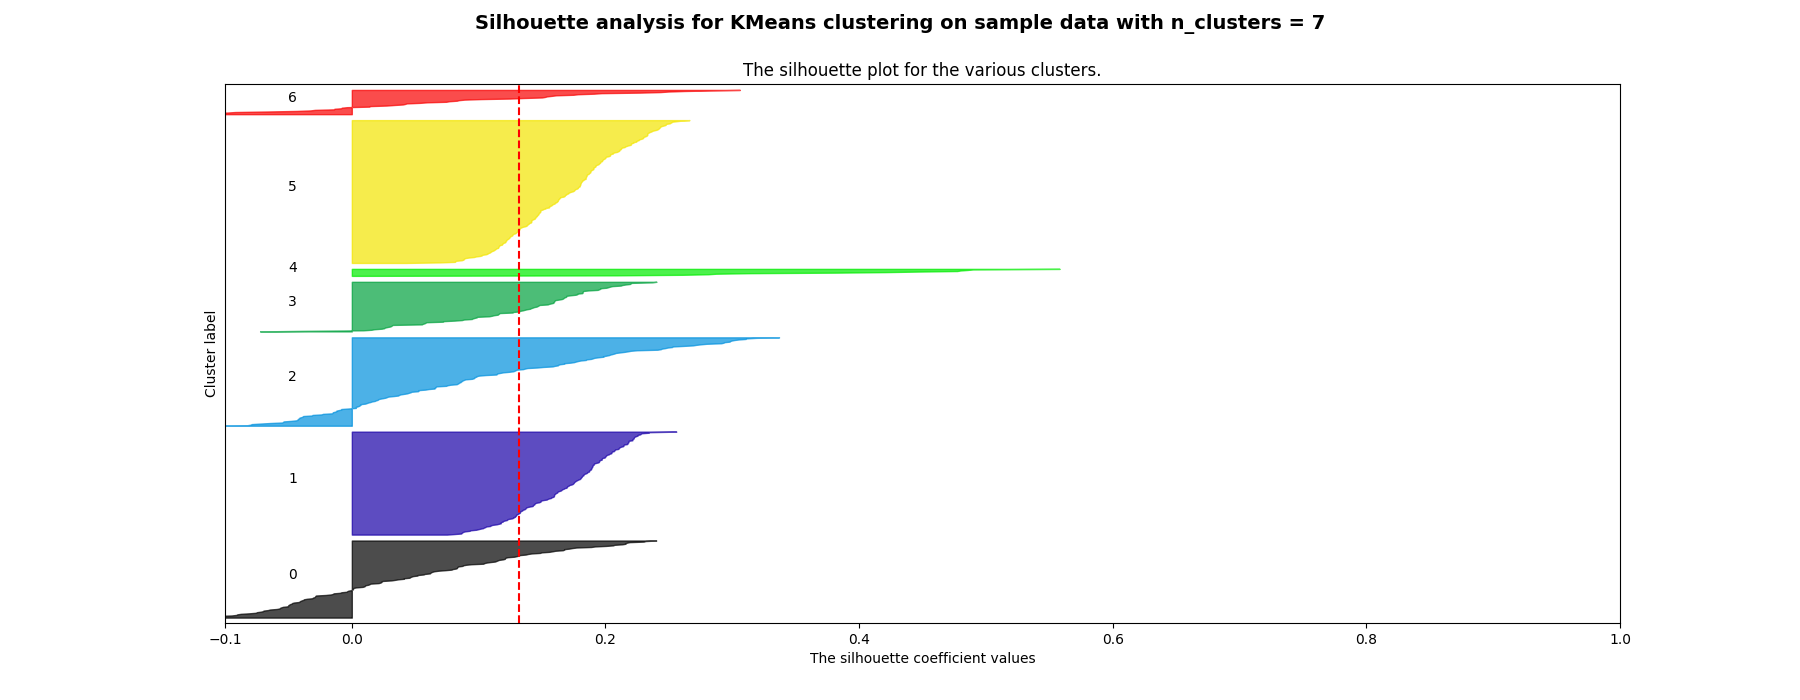

For n_clusters = 7 The average silhouette_score is : 0.13185394784978574


<IPython.core.display.Javascript object>


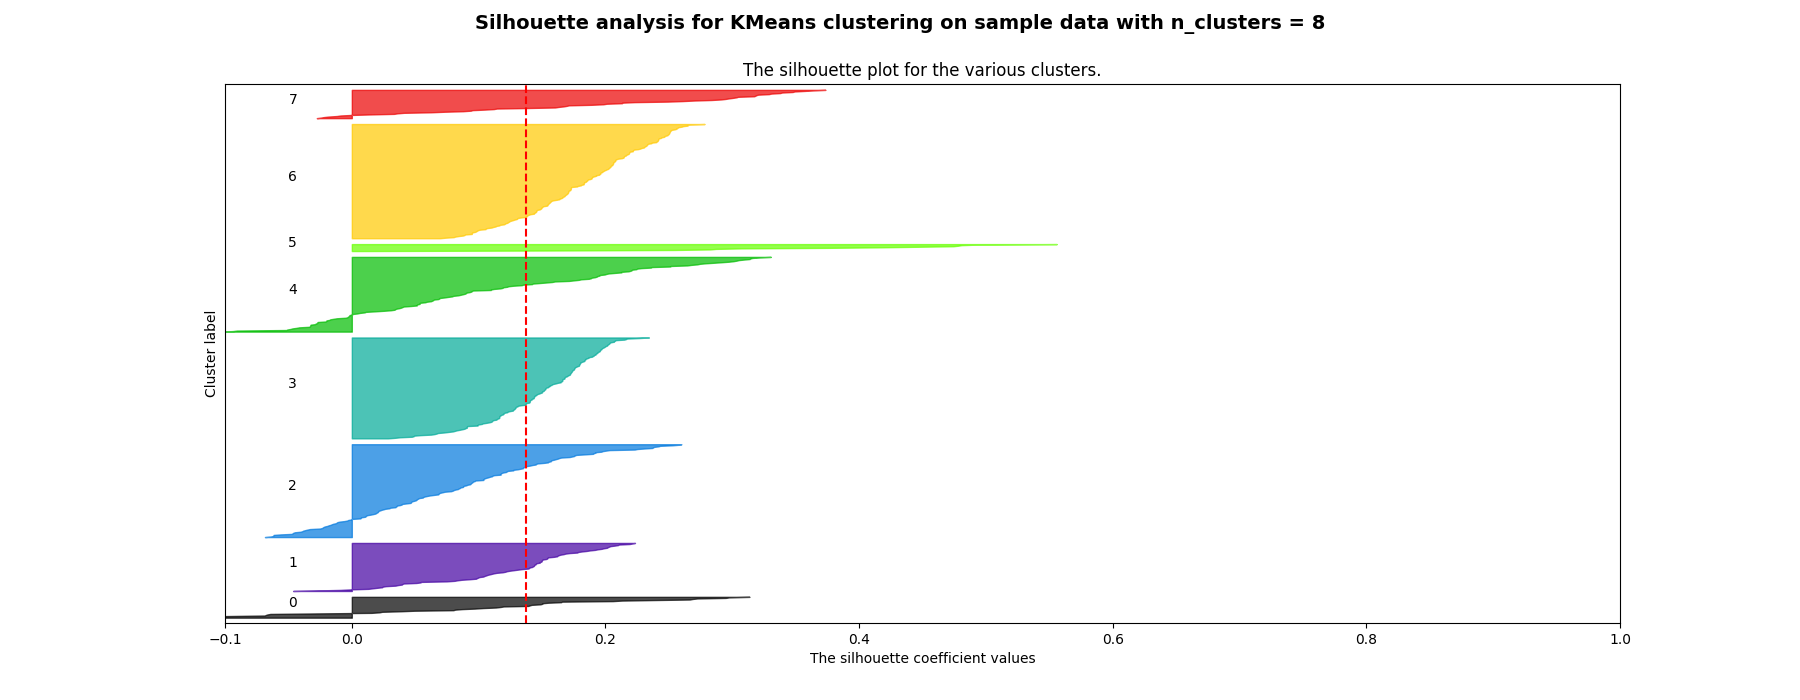

For n_clusters = 8 The average silhouette_score is : 0.13743350675838198


In [10]:
%matplotlib notebook

n_clusters_list = [4,6,7,8]
for n in n_clusters_list:
    n_cluster_kmean =n
    km = KMeans(n_clusters=n_cluster_kmean, random_state=10)
    km.fit(X_scaled.drop(['artists','song_name'], axis=1))
    title = "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_cluster_kmean
    print_Silohuette(n_cluster_kmean, km.labels_, X_scaled.drop(['artists','song_name'], axis=1), title)



Con 4 clusters tenemos 4 clusters bien poblados, con score considerable. Por otro lado pareciera que haciendo clustering con 8 clusters se puede llegar a encontrar una distribución uniforme de los datos a lo largo de los clusters.

Los valores de k elegidos de acuerdo a estas dos reglas son:
- k1 = 4
- k2 = 8

### 3) Correr K-Means con los k elegidos

En este punto corremos de nuevo el algoritmo con los __k1__ y __k2__ elegidos en __2)__ y almacenaremos los resultados obtenidos en __X_preds_k1__ y __X_preds_k2__. El output de la predicción es un conjunto de __n__ (= #Canciones) etiquetas que nos dicen en qué cluster está cada canción __Xi__.

In [4]:
k1_nclusters = 4
k2_nclusters = 8
km_n_k1 = KMeans(n_clusters=k1_nclusters, random_state=10)
km_n_k2 = KMeans(n_clusters=k2_nclusters, random_state=10)

X_preds_k1 = km_n_k1.fit(X_scaled.drop(['artists','song_name'], axis=1)).labels_
X_preds_k2 = km_n_k2.fit(X_scaled.drop(['artists','song_name'], axis=1)).labels_

song_clusters_k1 = df_features_scale.copy()
song_clusters_k1['cluster'] = X_preds_k1

song_clusters_k2 = df_features_scale.copy()
song_clusters_k2['cluster'] = X_preds_k2

### 4) Graficar los clusters obtenidos

Graficamos los clusters que obtuvimos en el ejercicio anterior. Previamente, se debe realizar una reducción de dimensiones al conjunto de datos __X_scaled__ para poder graficar los puntos dos y tres dimensiones, respectivamente. Por último, los colores de los puntos graficados estarán dados por cluster al que pertenece cada canción.

<IPython.core.display.Javascript object>


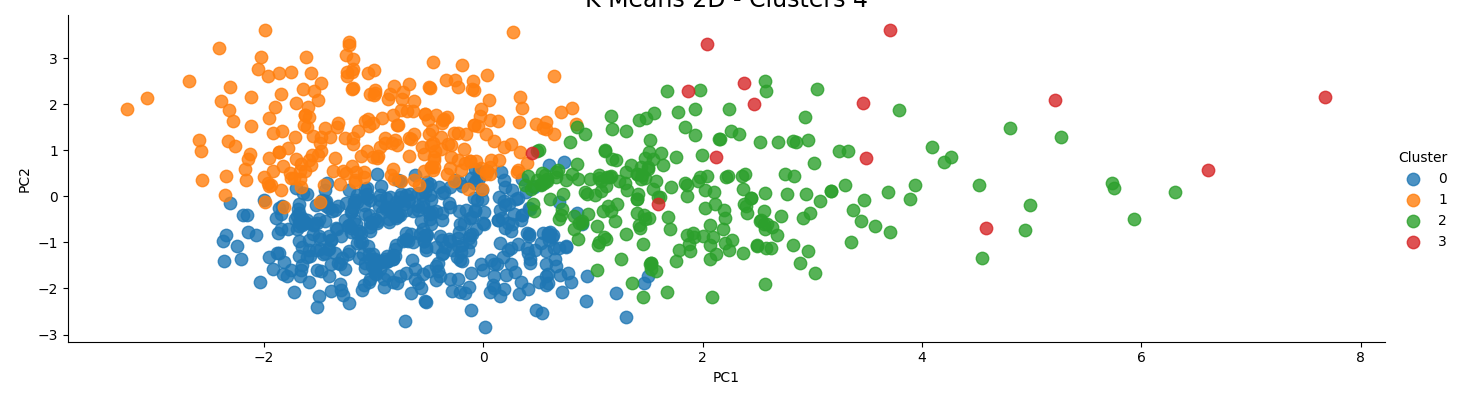

<IPython.core.display.Javascript object>


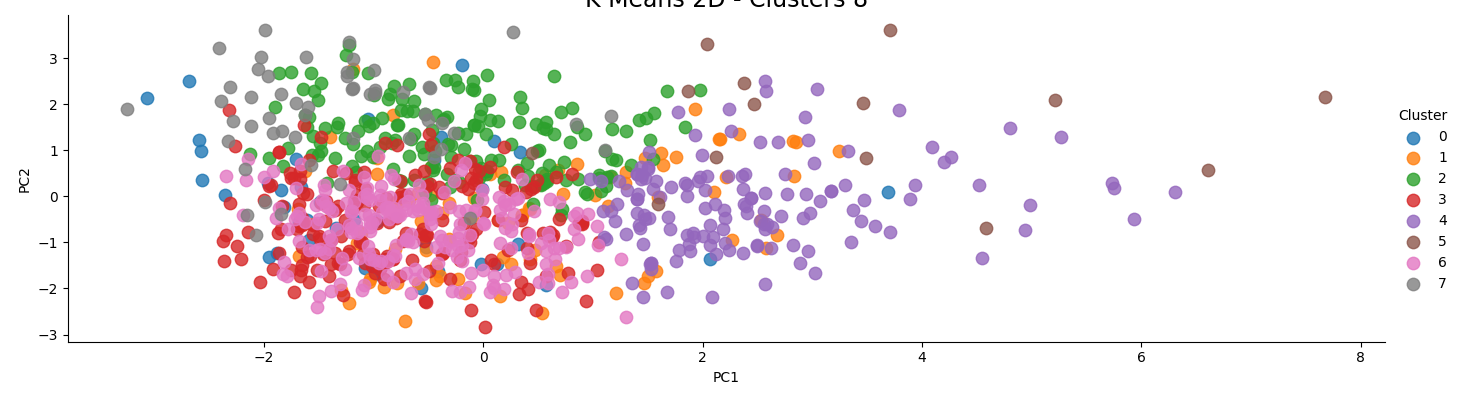

[]

In [8]:
%matplotlib notebook

pca_2D = decomposition.PCA(n_components=2, random_state=42)
pca_3D = decomposition.PCA(n_components=3, random_state=42)

pc_2D = pca_2D.fit_transform(X_scaled.drop(['artists','song_name'], axis=1))


df_pca_2D_k1 = pd.DataFrame(data=pc_2D, columns=['PC1', 'PC2'])
df_pca_2D_k1['Cluster'] = X_preds_k1

df_pca_2D_k2 = pd.DataFrame(data=pc_2D, columns=['PC1', 'PC2'])
df_pca_2D_k2['Cluster'] = X_preds_k2

sns.lmplot(x='PC1', y='PC2', data=df_pca_2D_k1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {}".format(k1_nclusters), fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=df_pca_2D_k2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {}".format(k2_nclusters), fontsize=17)
plt.plot()

Vemos en estos PCAs 2D que los datos no están separados y correr PCA no pareciera implicar ganancia de conocimiento respecto a posibles clusters o causas latentes en la distribución espacial de los datos.

<IPython.core.display.Javascript object>


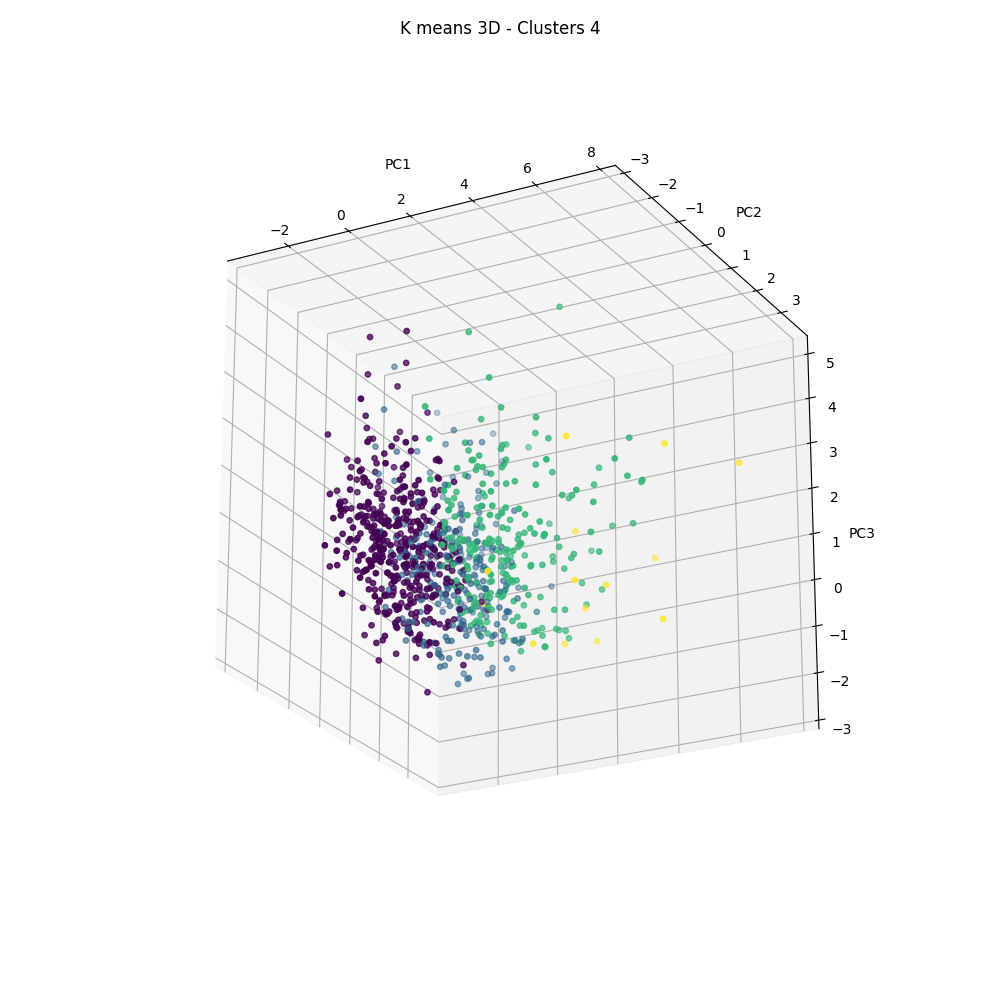

In [11]:
%matplotlib notebook

pca_3D = decomposition.PCA(n_components=3, random_state=42)

pc_3D = pca_3D.fit_transform(X_scaled.drop(['artists','song_name'], axis=1))

df_pca_3D_k1 = pd.DataFrame(data=pc_3D, columns=['PC1', 'PC2', 'PC3'])
df_pca_3D_k1['Cluster'] = X_preds_k1

fig = plt.figure(figsize=(10,10))
fig.suptitle('K means 3D - Clusters {}'.format(k1_nclusters))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3D_k1['PC1'], df_pca_3D_k1['PC2'], df_pca_3D_k1['PC3'], c=df_pca_3D_k1['Cluster'], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

<IPython.core.display.Javascript object>


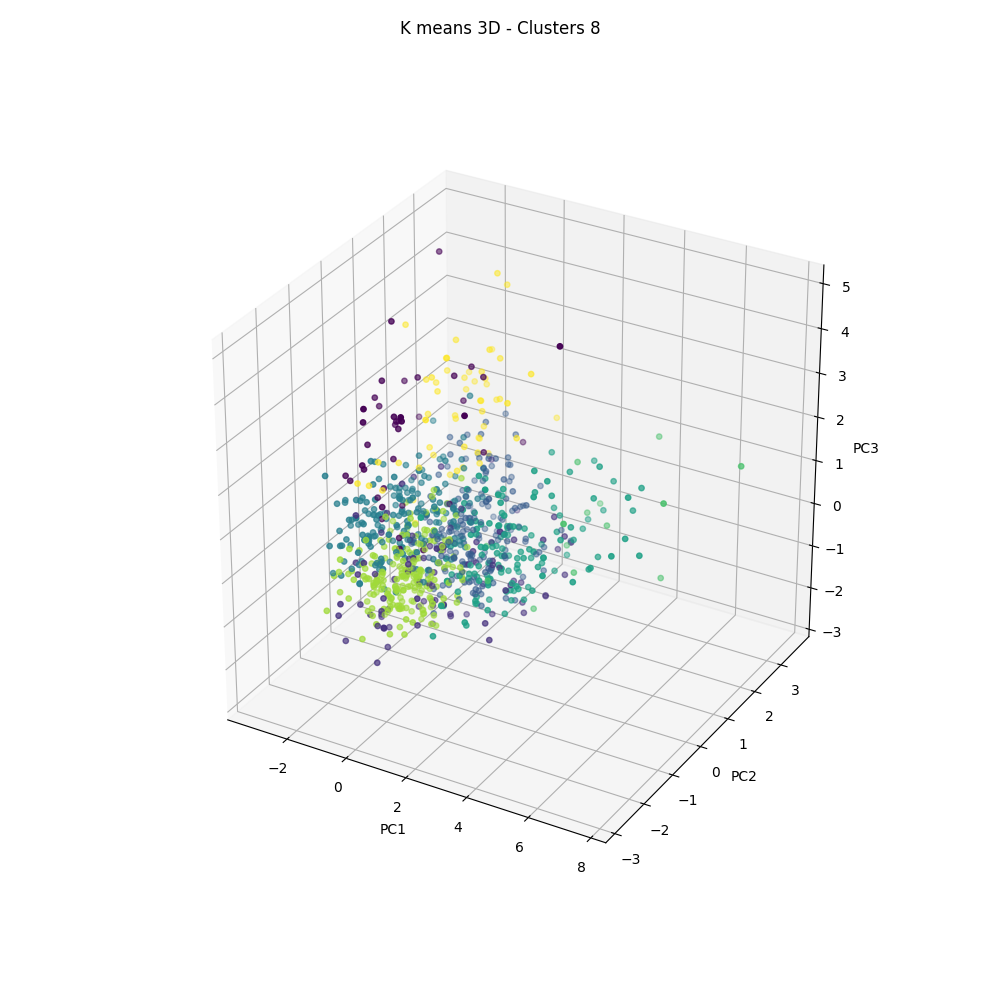

In [12]:
%matplotlib notebook

df_pca_3D_k2 = pd.DataFrame(data=pc_3D, columns=['PC1', 'PC2', 'PC3'])
df_pca_3D_k2['Cluster'] = X_preds_k2



fig = plt.figure(figsize=(10,10))
fig.suptitle('K means 3D - Clusters {}'.format(k2_nclusters))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3D_k2['PC1'], df_pca_3D_k2['PC2'], df_pca_3D_k2['PC3'], c=df_pca_3D_k2['Cluster'], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

Igualmente con estos PCAs 3D, podemos ver que el PCA 2D efectivamente encontró la proyección con separación máxima, pero los datos no están separados y no obtuvimos nuevos conocimientos.

### 5) Informe

Por último, deberán escribir un informe en el cual:
1. Muestren los clusters obtenidos en __3)__ como listas de canciones
2. Describan cualitativamente (e intuitivamente) estos clusters para cada __k__ elegido de acuerdo al contenido de los mismos, por ejemplo: 
    - El cluster 1 presenta canciones de géneros subsaharianos y es el más amplio debido a que..., el 2 de géneros tribales del cuerno de África, el 3...
    - Los clusters x0, x1, ... , xn no presentan algún patrón observable, pero xn+1 y xn+4 tienen...
4. Digan cuál k les dio resultados más coherentes y/o interpretables
5. Comparen los resultados obtenidos con aprendizaje no supervisado (con el mejor de los dos k) vs supervisado de manera cualitativa. Por ejemplo: nos parece mejor/peor/distinto/indistinto el modelo de aprendizaje no supervisado/supervisado en esta tarea porque...




## Análisis de Clústers

In [5]:
warnings.filterwarnings('ignore')
song_clusters_k1['artists'] = song_clusters_k1['artists'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True)
cluster_1 = song_clusters_k1[song_clusters_k1["cluster"] == 1]
cluster_2 = song_clusters_k1[song_clusters_k1["cluster"] == 2]
cluster_3 = song_clusters_k1[song_clusters_k1["cluster"] == 3]
cluster_4 = song_clusters_k1[song_clusters_k1["cluster"] == 0]


In [119]:
clusters = [cluster_1,cluster_2,cluster_3,cluster_4]
i = 1
for clus in clusters:
    print(f'El cluster {i} tiene {len(clus)} elementos')
    i += 1

El cluster 1 tiene 241 elementos
El cluster 2 tiene 235 elementos
El cluster 3 tiene 14 elementos
El cluster 4 tiene 430 elementos


In [81]:
cluster_1.sample(5)[["artists","song_name"]]

,artists,song_name
498,La Oreja de Van Gogh,Deseos de Cosas Imposibles (with Abel Pintos) ...
644,Callejeros,Presión
259,Hermetica,La Revancha de America
874,WOS,LUZ DELITO
507,La Oreja de Van Gogh,Verano


In [80]:
cluster_2.sample(5)[["artists","song_name"]]

,artists,song_name
166,Luis Miguel,Contigo En La Distancia
486,Luis Miguel,Perfidia
152,Luis Miguel,Si tú te atreves
327,La Oreja de Van Gogh,Tu y Yo
4,Juan Gabriel,Querida


In [79]:
cluster_3.sample(5)[["artists","song_name"]]

,artists,song_name
57,Soda Stereo,En la Ciudad de la Furia
918,Bandalos Chinos,Ácido
225,Eruca Sativa,Intropía
263,Hermetica,Horizonte Perdido
287,Arca,Piel


In [78]:
cluster_4.sample(5)[["artists","song_name"]]

,artists,song_name
487,La Oreja de Van Gogh,Cuídate
46,Nestor En Bloque,Una Calle Nos Separa
502,La Oreja de Van Gogh,Soledad
672,Daddy Yankee,Impacto
611,Calle 13,La Vuelta Al Mundo


In [91]:
df = song_clusters_k1.copy()
df_by_artist = df.set_index('artists')

#artistas destacados a seguir
artists = ["Luis Miguel", "Arca", "Hermetica", 
           "WOS", "Los Piojos", "Árbol", "Damas Gratis", "Mala Fama", "La Mona Jimenez",
          "Sabroso", "La Barra", "Rodrigo", "Raphael","Chayanne","Almafuerte",'Daddy Yankee']

def distrs_of_clusters_by_artists(artists_list=artists,df=df_by_artist): # [str] -> DataFrame -> [DataFrame]
    dists = []
    
    for artist in artists_list:
        artist_distr = pd.DataFrame(df[df.index.str.startswith(artist)]['cluster'],columns=["cluster"])
        artist_distr.index = np.arange(0, len(artist_distr))
        dists.append(artist_distr)
    return dists
dists = distrs_of_clusters_by_artists()

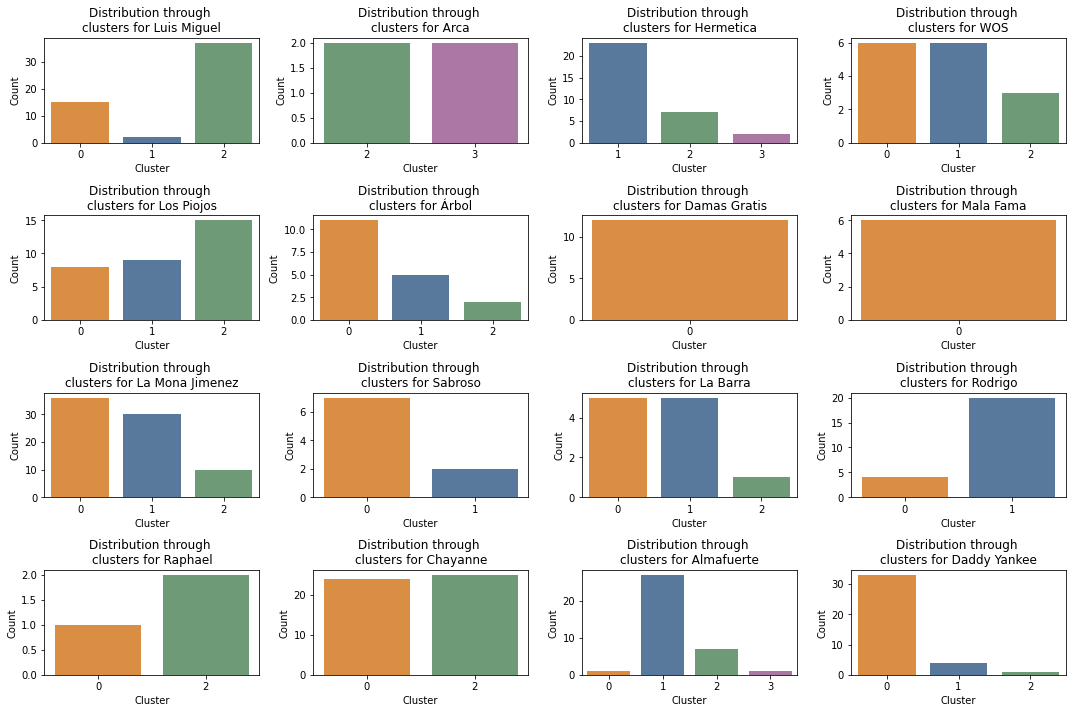

In [18]:
%matplotlib inline
i=0
colors = {0: "#F28E2B", 1: "#4E79A7", 2: "#68a172", 3: "#b370aa"}
fig, axs = plt.subplots(4, 4, figsize=(15,10))
for j in range(4):
    for k in range(4):
        sns.barplot(x=dists[i].cluster.value_counts().index,y=dists[i].cluster.value_counts(),ax=axs[j,k],palette=colors)
        axs[j,k].set_title(f'Distribution through \nclusters for {artists[i]}')
        i+=1

for ax in axs.flat:
    ax.set(xlabel='Cluster', ylabel='Count')
fig.tight_layout(pad=1.05)
plt.show()

Viendo las distribuciones de las canciones de los artistas destacados podemos empezar a pensar qué información contienen los clústeres generados con Kmeans:

vemos que los artistas como Daddy Yankee, Mala Fama, Damas Gratis, La Mona y La barra presentan distribuciones parecidas. 

Damas Gratis y Mala Fama presentan la misma distribución, estando sus canciones solamente en el clúster 0

Analicemos ahora más a fondo haciendo foco en algunos artistas destacados para poder deducir qué información nos aporta cada clúster. Para esto sacaremos la media de los valores de las features para cada artista, en las canciones de cada clúster. Si necesitás refrescar el significado de las features de audio ver [la documentación de Spotify](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/)

In [120]:
clusters = [cluster_4, cluster_1,cluster_2, cluster_3]
def compare_across_clusters(*,clusters=clusters, artist='La Oreja de Van Gogh'):
    s = []
    i=0
    print(f'Comparision between clusters for artist: {artist}')
    for cluster in clusters:
        s.append(pd.merge(X_unscaled, cluster, how='inner', on=['song_name']))
        data = s[i][s[i]['artists_y']==artist].mean()
        if not np.isnan(data.lyrics_sentiment_x):
            print("⚫ Cluster ", i , " has:\nlyrics_sentiment: ",round(data.lyrics_sentiment_x,4), "|| valence: ", round(data.valence_x,4),
             " || speechiness: ", round(data.speechiness_x,4), "|| danceability: ", round(data.danceability_x,4),
             "|| energy: ",round(data.energy_x,4), "|| loudness: ",round(data.loudness_x,4),
             "|| instrumentalness: ",round(data.instrumentalness_x,4), "|| liveness: ",round(data.liveness_x,4),
             "|| tempo: ",round(data.tempo_x,4), "|| mode: ",round(data.mode_x,4),"|| key: ",round(data.key_x,4),
             )
        else:
            print(f"⚫ {artist} doesn't have songs in Cluster {i}")
        i+=1

compare_across_clusters()

Comparision between clusters for artist: La Oreja de Van Gogh
⚫ Cluster  0  has:
lyrics_sentiment:  0.1747 || valence:  0.6096  || speechiness:  0.0352 || danceability:  0.6392 || energy:  0.7659 || loudness:  -4.8028 || instrumentalness:  0.0017 || liveness:  0.1245 || tempo:  132.2387 || mode:  0.6538 || key:  6.1154
⚫ Cluster  1  has:
lyrics_sentiment:  0.0266 || valence:  0.4136  || speechiness:  0.053 || danceability:  0.5464 || energy:  0.7298 || loudness:  -6.013 || instrumentalness:  0.0001 || liveness:  0.4715 || tempo:  139.2449 || mode:  0.7273 || key:  5.7273
⚫ Cluster  2  has:
lyrics_sentiment:  0.1411 || valence:  0.3343  || speechiness:  0.0342 || danceability:  0.5502 || energy:  0.5486 || loudness:  -6.7903 || instrumentalness:  0.001 || liveness:  0.1037 || tempo:  119.6409 || mode:  0.9444 || key:  5.5
⚫ La Oreja de Van Gogh doesn't have songs in Cluster 3


#### Analizando el caso de La Oreja de Van Gogh
En el **Cluster 0** tenemos las **lyrics_sentiment, valence, danceability y energy más altas** de todos los clústeres. Nos indica que son las canciones más animadas, probablemente más "pop" en términos de géneros musicales.

Vemos en el **Cluster 1** un valor **alto para liveness y energy**, es decir que Spotify detectó presencia de audiencia en la grabación de la canción. Además el **tempo más alto** a lo largo de los clústeres. Estos datos contradicen lo que uno espera de canciones con tan **bajo lyrics_sentiment**, además conociendo que la mayoría de las canciones de esta banda son canciones de amor/pop/baladas. Parecieran ser canciones de temas tristes pero energéticas y frenéticas. Habría que ver cómo se comporta este clúster respecto a otros artistas. 

Vemos que en el **Cluster 2** las canciones tienen tanto **lyrics_sentiment bajo** como **valence bajo**: tanto musical como líricamente las canciones de La Oreja de Van Gogh en este cluster son "negativas". Vemos que además presenta la media de **loudness, tempo, y energy** más baja a lo largo de los clústeres. Una hipótesis inmediata a la hora de analizar esto sería que en este clúster están las canciones de desamor, baladas tristes/melancólicas, o bien canciones íntimas/intimistas. La **key** media de estas canciones también son un poco más bajas que en el resto de los clústeres.

Veamos cómo si estas hipótesis se mantienen para el resto de algunos otros artistas.

In [51]:
compare_across_clusters(artist='Almafuerte')

Comparision between clusters for artist: Almafuerte
⚫ Cluster  0  has:
lyrics_sentiment:  0.0 || valence:  0.561  || speechiness:  0.0756 || danceability:  0.577 || energy:  0.85 || loudness:  -7.099 || instrumentalness:  0.0 || liveness:  0.11 || tempo:  116.968 || mode:  1.0 || key:  0.0
⚫ Cluster  1  has:
lyrics_sentiment:  0.0926 || valence:  0.4316  || speechiness:  0.0779 || danceability:  0.3752 || energy:  0.8791 || loudness:  -4.8927 || instrumentalness:  0.0008 || liveness:  0.2884 || tempo:  122.5796 || mode:  0.5517 || key:  5.5517
⚫ Cluster  2  has:
lyrics_sentiment:  0.0 || valence:  0.3889  || speechiness:  0.0532 || danceability:  0.5359 || energy:  0.5364 || loudness:  -7.21 || instrumentalness:  0.0 || liveness:  0.1306 || tempo:  99.7691 || mode:  0.5714 || key:  5.8571
⚫ Cluster  3  has:
lyrics_sentiment:  0.5047 || valence:  0.845  || speechiness:  0.0744 || danceability:  0.537 || energy:  0.377 || loudness:  -10.638 || instrumentalness:  0.944 || liveness:  0.105

#### Analizando el caso de Almafuerte
En el **Clúster 0** tenemos canciones con **muy bajo lyrics_sentiment y key** pero **energy y mode altos** y **valence, danceability y tempo medio**. Probablemente canciones animadas, frenéticas, que se relacionan probablemente a las canciones más metaleras de Almafuerte. Esto contradice la hipótesis que habíamos planteado a la hora de analizar La Oreja de Van Gogh, de que en el Clúster 0 hay canciones "pop". Una síntesis de estas dos observaciones sería que en el **Cluster 0** hay canciones frenéticas/eufóricas y regulares, más allá del género al que pertenezcan.

En el **Cluster 1** vemos de nuevo esta combinación de **bajo lyrics_sentiment, energía alta y tempo acelerado**. En comparación a las canciones del Clúster 0 tenemos **danceability bajo**. O sea que en comparación, las canciones del Clúster 1 son, para Spotify, canciones irregulares, o sin un beat fácilmente reconocible.

Para 'La Oreja de Van Gogh' habíamos dicho que el **Cluster 2** tiene canciones lentas, probablemente baladas o sino canciones intimistas. En este caso observamos lo mismo para las canciones de Almafuerte, ya que tenemos las mismas tendencias: **bajo tempo, lyrics_sentiment y valence**.

En el **Cluster 3** tenemos canciones con medias para **lyrics_sentiment y valence más altas** para Almafuerte. Además tienen **muy alto instrumentalness**. Parecieran ser canciones con predominancia instrumental. Sorprenden los valores de lyrics_sentiment y valence respecto a **energy, tempo, mode, y key bajos**. Tienen **mode bajo**, es decir Minor. Culturalmente percibimos canciones en minor mode como "negativas", donde se presentan "problemas". Para entender más sobre este cluster tenemos que ver cómo se da en otros artistas.

In [62]:
compare_across_clusters(artist='Hermetica')

Comparision between clusters for artist: Hermetica
⚫ Hermetica doesn't have songs in Cluster 0
⚫ Cluster  1  has:
lyrics_sentiment:  0.0001 || valence:  0.4393  || speechiness:  0.0775 || danceability:  0.3702 || energy:  0.8578 || loudness:  -8.6967 || instrumentalness:  0.0081 || liveness:  0.2465 || tempo:  135.809 || mode:  0.6923 || key:  6.5769
⚫ Cluster  2  has:
lyrics_sentiment:  0.0351 || valence:  0.3227  || speechiness:  0.0624 || danceability:  0.4019 || energy:  0.626 || loudness:  -11.372 || instrumentalness:  0.0032 || liveness:  0.1239 || tempo:  100.8207 || mode:  0.4286 || key:  3.5714
⚫ Cluster  3  has:
lyrics_sentiment:  0.7524 || valence:  0.314  || speechiness:  0.046 || danceability:  0.3555 || energy:  0.7995 || loudness:  -10.476 || instrumentalness:  0.863 || liveness:  0.1166 || tempo:  114.4285 || mode:  0.0 || key:  3.0


#### Analizando el caso de Hermética

En el **Cluster 1** tenemos canciones con **alto tempo, alta energy** y, nuevamente bajo **lyrics sentiment** y **medio valence**. La mayoría de las canciones de Hermética y Almafuerte del dataset están en este cluster. A diferencia del **Cluster 0**, tienen bajo **danceability**; Spotify no considera que sus canciones sean muy regulares.

En el **cluster 2** efectivamente se encuentran las baladas metaleras de Hermética, confirmando la hipótesis planteada en un principio del análisis.

Nuevamente en el caso de Hermética, en el **Cluster 3** nos encontramos con canciones instrumentales. La variación de lyrics_sentiment y valence respecto a otros artistas del mismo cluster hacen pensar que en este cluster **instrumentalness es la feature decisiva**. Entra en juego datos erróneos en el dataset, ya que estos valores de lyrics_sentiment son el resultado de ruido en el dataset (corresponden a sacar el lyrics sentiment de por ej "Instrumental" o "Sin letra").

In [67]:
compare_across_clusters(artist='Rodrigo')

Comparision between clusters for artist: Rodrigo
⚫ Cluster  0  has:
lyrics_sentiment:  0.3993 || valence:  0.8012  || speechiness:  0.0397 || danceability:  0.5994 || energy:  0.7976 || loudness:  -7.7176 || instrumentalness:  0.0006 || liveness:  0.378 || tempo:  147.3534 || mode:  0.8 || key:  3.6
⚫ Cluster  1  has:
lyrics_sentiment:  0.0285 || valence:  0.6379  || speechiness:  0.0743 || danceability:  0.4365 || energy:  0.8835 || loudness:  -6.8795 || instrumentalness:  0.0001 || liveness:  0.5856 || tempo:  152.9023 || mode:  0.6286 || key:  6.1429
⚫ Rodrigo doesn't have songs in Cluster 2
⚫ Rodrigo doesn't have songs in Cluster 3


#### Analisis de Rodrigo
Ambos clusters en este caso presentan canciones frenéticas (**energy y tempo altos**), las diferencias se observan en **danceability y liveness**.

In [54]:
compare_across_clusters(artist='Soda Stereo')

Comparision between clusters for artist: Soda Stereo
⚫ Cluster  0  has:
lyrics_sentiment:  0.205 || valence:  0.5485  || speechiness:  0.0483 || danceability:  0.581 || energy:  0.913 || loudness:  -5.076 || instrumentalness:  0.0058 || liveness:  0.0862 || tempo:  100.9425 || mode:  0.5 || key:  7.5
⚫ Soda Stereo doesn't have songs in Cluster 1
⚫ Soda Stereo doesn't have songs in Cluster 2
⚫ Cluster  3  has:
lyrics_sentiment:  0.0 || valence:  0.731  || speechiness:  0.0292 || danceability:  0.615 || energy:  0.833 || loudness:  -5.377 || instrumentalness:  0.696 || liveness:  0.463 || tempo:  126.519 || mode:  1.0 || key:  2.0


#### Analizando el caso de Soda Stereo
Veniamos con la hipótesis de que el **Cluster 0** era un clúster con canciones eufóricas/frenéticas/"bailables". Podemos ver Esta misma característica en las canciones de Soda Stereo, con un **energy muy alto**

Vemos en el **Cluster 3** se comparte el **valence, key, instrumentalness altos**, mientras que difieren con el caso de Almafuerte, ya que tiene **energy, mode, tempo altos**

In [125]:
def compare_across_clusters_all_artists(*,clusters=clusters):
    s = []
    i=0
    print(f'Comparision between clusters for all artists')
    for cluster in clusters:
        s.append(pd.merge(X_unscaled, cluster, how='inner', on=['song_name']))
        data = s[i].mean()
        if not np.isnan(data.lyrics_sentiment_x):
            print("⚫ Cluster ", i , " has:\nlyrics_sentiment: ",round(data.lyrics_sentiment_x,4), "|| valence: ", round(data.valence_x,4),
             " || speechiness: ", round(data.speechiness_x,4), "|| danceability: ", round(data.danceability_x,4),
             "|| energy: ",round(data.energy_x,4), "|| loudness: ",round(data.loudness_x,4),
             "|| instrumentalness: ",round(data.instrumentalness_x,4), "|| liveness: ",round(data.liveness_x,4),
             "|| tempo: ",round(data.tempo_x,4), "|| mode: ",round(data.mode_x,4),"|| key: ",round(data.key_x,4),
             )
            #print(len(s[i]))
        i+=1

compare_across_clusters_all_artists()

Comparision between clusters for all artists
⚫ Cluster  0  has:
lyrics_sentiment:  0.1379 || valence:  0.7455  || speechiness:  0.0664 || danceability:  0.6833 || energy:  0.7717 || loudness:  -5.5433 || instrumentalness:  0.0072 || liveness:  0.1723 || tempo:  124.1873 || mode:  0.597 || key:  5.3211
⚫ Cluster  1  has:
lyrics_sentiment:  0.0564 || valence:  0.5538  || speechiness:  0.0934 || danceability:  0.4587 || energy:  0.8599 || loudness:  -5.6768 || instrumentalness:  0.0041 || liveness:  0.3977 || tempo:  140.2675 || mode:  0.6052 || key:  5.7232
⚫ Cluster  2  has:
lyrics_sentiment:  0.1828 || valence:  0.3933  || speechiness:  0.0404 || danceability:  0.5293 || energy:  0.5204 || loudness:  -8.832 || instrumentalness:  0.0063 || liveness:  0.1493 || tempo:  116.4385 || mode:  0.7171 || key:  4.7331
⚫ Cluster  3  has:
lyrics_sentiment:  0.331 || valence:  0.3607  || speechiness:  0.0401 || danceability:  0.4347 || energy:  0.5874 || loudness:  -10.8018 || instrumentalness:  0.

### Conclusión del Análisis de Clusteres

Reuniendo la información que analizamos podemos concluir que los clústeres se corresponden con:
- **Cluster 0**: canciones frenéticas y/o bailables, de muchos géneros. En este caso el "sentimiento" de la canción no fue considerado, y hay tanto canciones "positivas" como "negativas", mientras sean energéticas y regulares.
- **Cluster 1**: canciones frenéticas con ritmos "menos regulares" para spotify, y con "sentimiento" un poco más "negativo" que las del cluster 0 en general. Además en general las canciones de este clúster tienen un score más alto de "liveness". Hay canciones de muchos géneros distintos pero que compraten estas características.
- **Cluster 2**: baladas de distintos géneros, ya sean baladas de pop o de rock/metal, se encuentran acá.
- **Cluster 3**: canciones que son "instrumentales" (o bien lo son realmente, o lo son para spotify), esto explica que sea tan chico el cluster. No deberían haber canciones instrumentales en el dataset, pero lo hay por errores en su construcción.


## Segunda Parte: No supervisado enfocado en sentiment features

Tenemos features relacionados a componentes afectivas de las canciones en el dataset. 

Es de especial interés ver qué conocimientos podemos derivar de estudiar estos componentes afectivos, con el fin de poder, en un futuro, incorporar estos distintos entendimientos a un modelo, para tener algoritmos más holísticos respecto a su "inteligencia".

Respecto a la computación afectiva Rosalind Picard afirma

> "The human brain, in both males and females, relies on emotion in normal thinking. In other words, even the most rational thinking requires participation from the emotion-mediating parts of the brain. Consequently, affective computers should not be considered more feminine, but more human." [Rosalind Picard - Affective Computing - 2000]


In [95]:
X_scaled.columns

Index(['lyrics_sentiment', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'song_name', 'artists'],
      dtype='object')

In [96]:
X_scaled_sentiment = X_scaled[['lyrics_sentiment','valence','song_name','artists']]

<IPython.core.display.Javascript object>


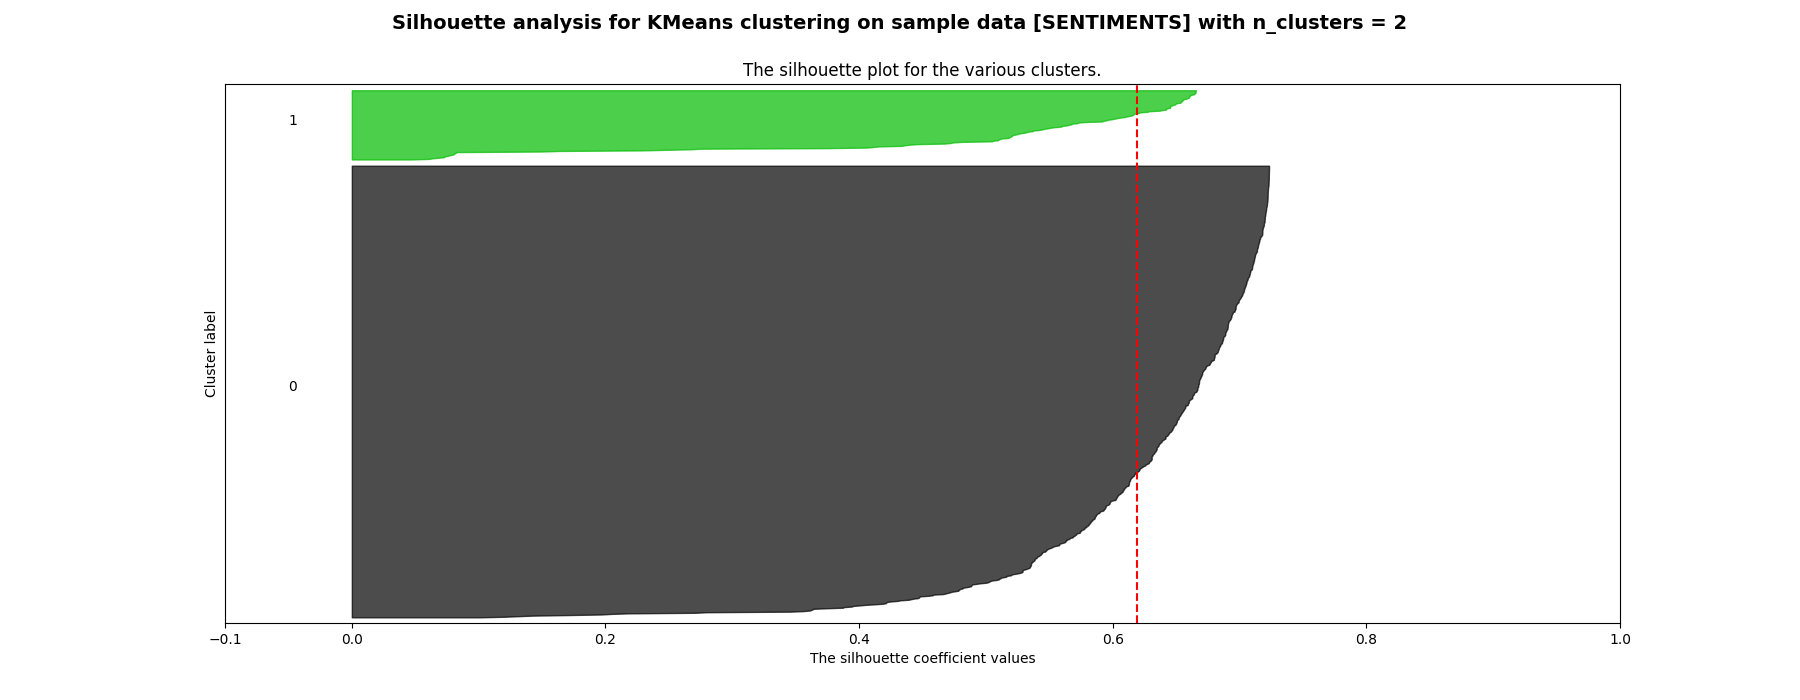

For n_clusters = 2 The average silhouette_score is : 0.619121441674431


<IPython.core.display.Javascript object>


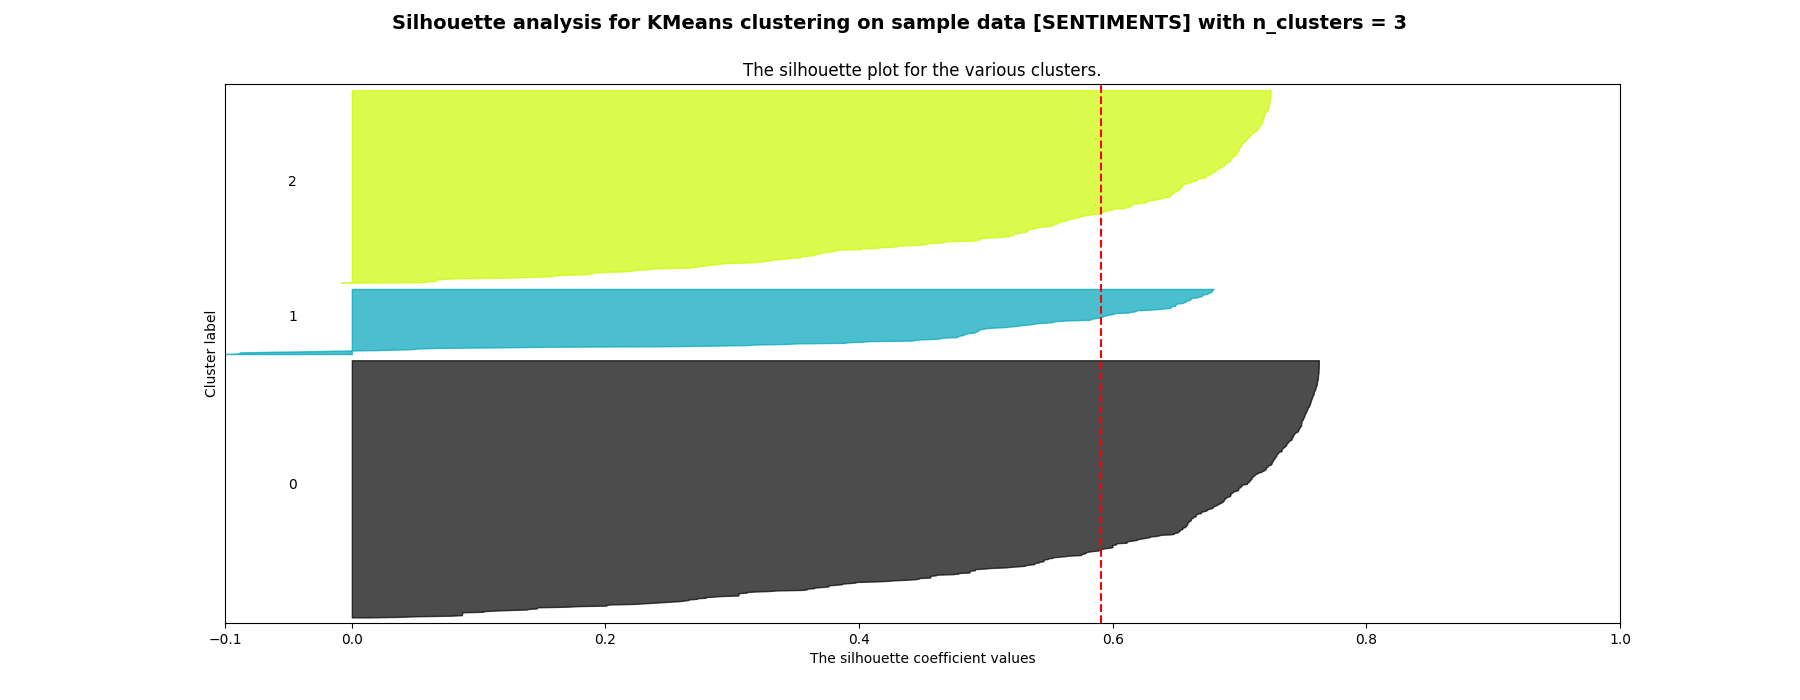

For n_clusters = 3 The average silhouette_score is : 0.5908019042012598


<IPython.core.display.Javascript object>


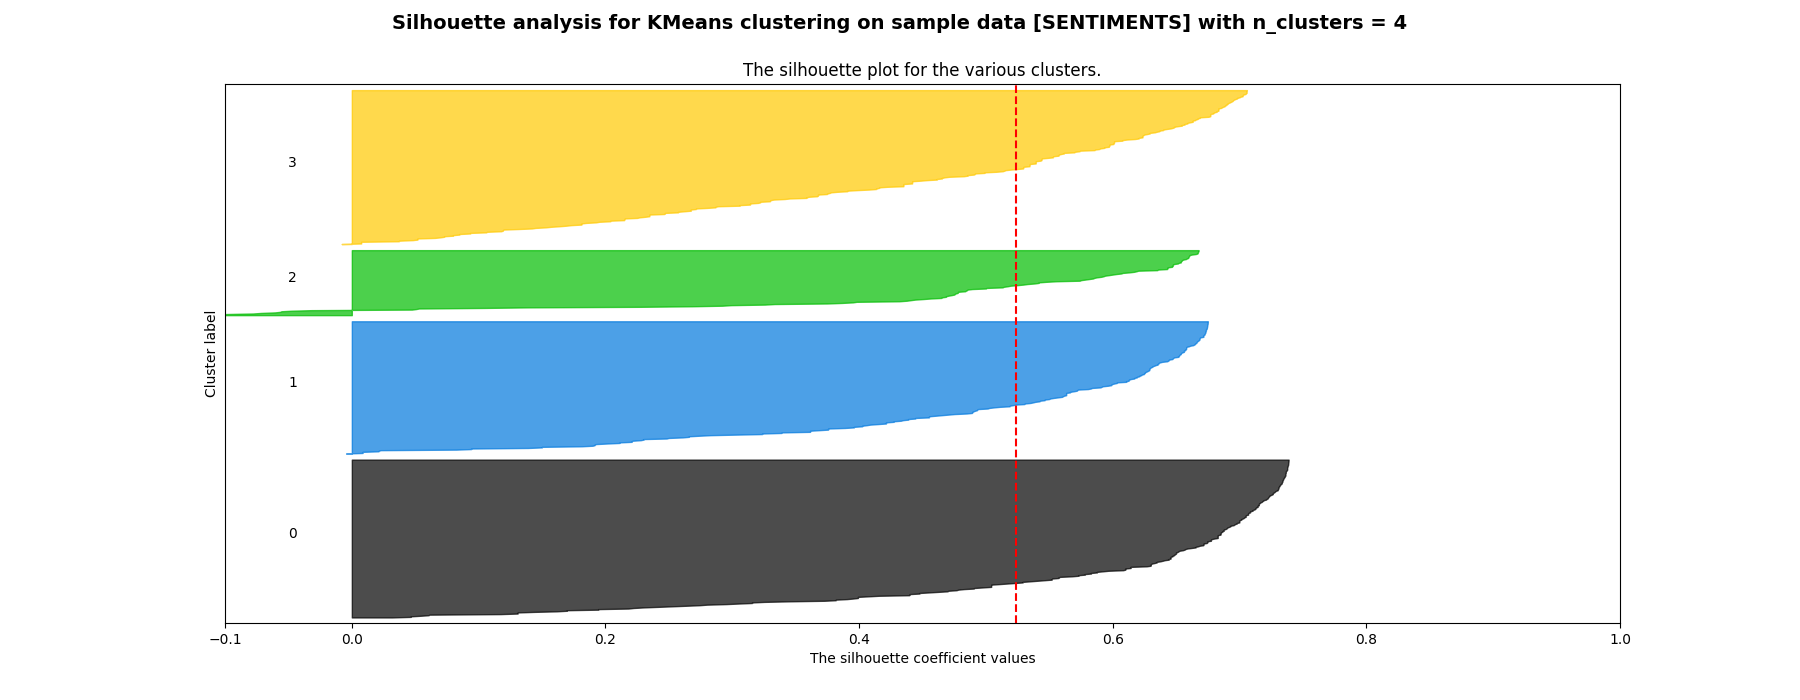

For n_clusters = 4 The average silhouette_score is : 0.523375388097964


<IPython.core.display.Javascript object>


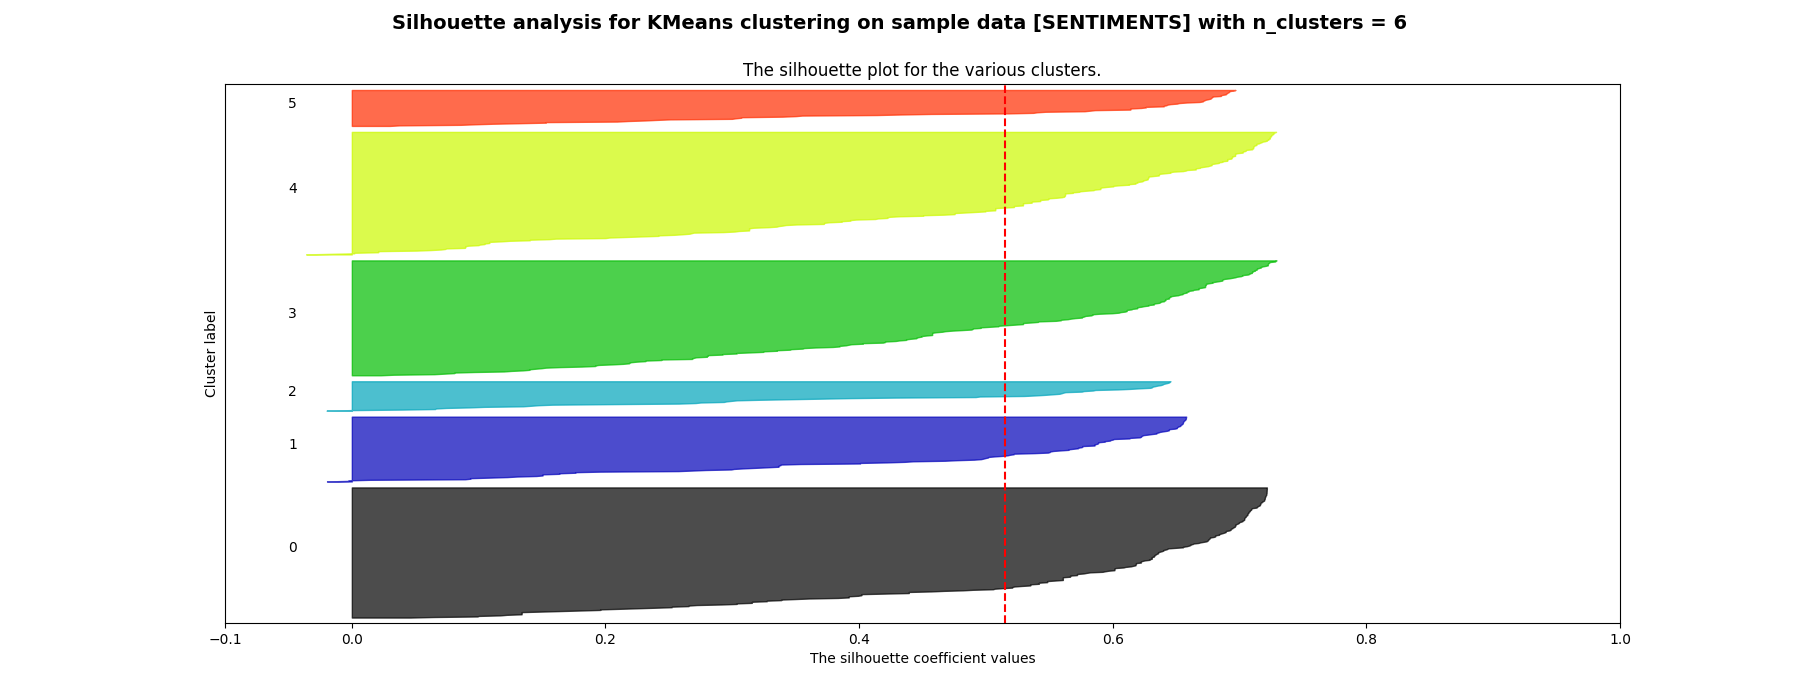

For n_clusters = 6 The average silhouette_score is : 0.5146789410985212


In [97]:
%matplotlib notebook

n_clusters_list = [2,3,4,6]
for n in n_clusters_list:
    n_cluster_kmean =n
    km_s = KMeans(n_clusters=n_cluster_kmean, random_state=10)
    km_s.fit(X_scaled_sentiment.drop(['artists','song_name'], axis=1))
    title = "Silhouette analysis for KMeans clustering on sample data [SENTIMENTS] with n_clusters = %d" % n_cluster_kmean
    print_Silohuette(n_cluster_kmean, km_s.labels_, X_scaled_sentiment.drop(['artists','song_name'], axis=1), title)



In [98]:
k1_nclusters = 4
k2_nclusters = 2
km_n_k1 = KMeans(n_clusters=k1_nclusters, random_state=10)
km_n_k2 = KMeans(n_clusters=k2_nclusters, random_state=10)

sentiment_X_preds_k1 = km_n_k1.fit(X_scaled_sentiment.drop(['artists','song_name'], axis=1)).labels_
sentiment_X_preds_k2 = km_n_k2.fit(X_scaled_sentiment.drop(['artists','song_name'], axis=1)).labels_

sent_song_clusters_k1 = df_features_scale.copy()
sent_song_clusters_k1['cluster'] = sentiment_X_preds_k1

sent_song_clusters_k2 = df_features_scale.copy()
sent_song_clusters_k2['cluster'] = sentiment_X_preds_k2

## PCA on sentiment dataset

<IPython.core.display.Javascript object>


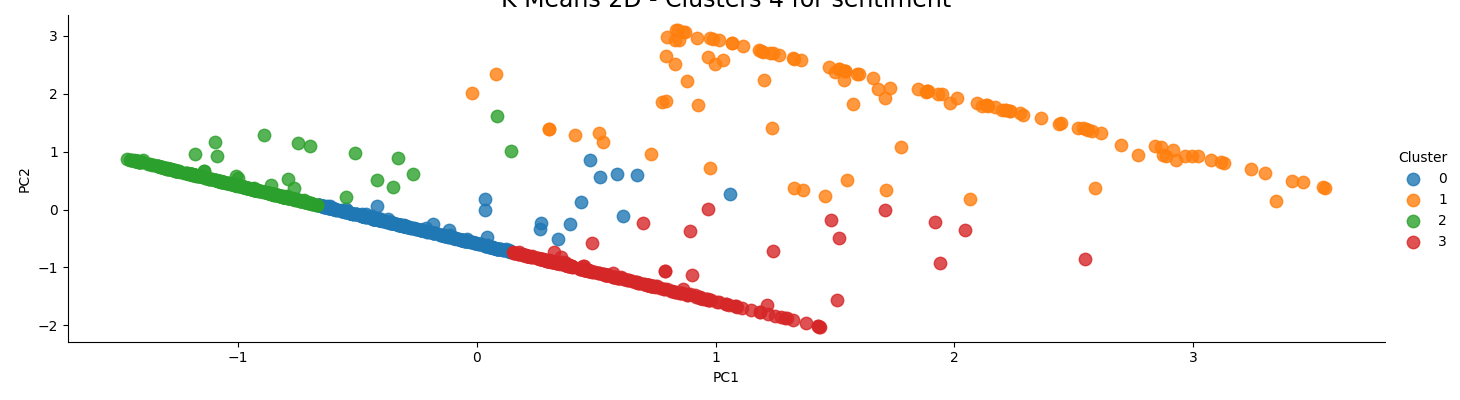

<IPython.core.display.Javascript object>


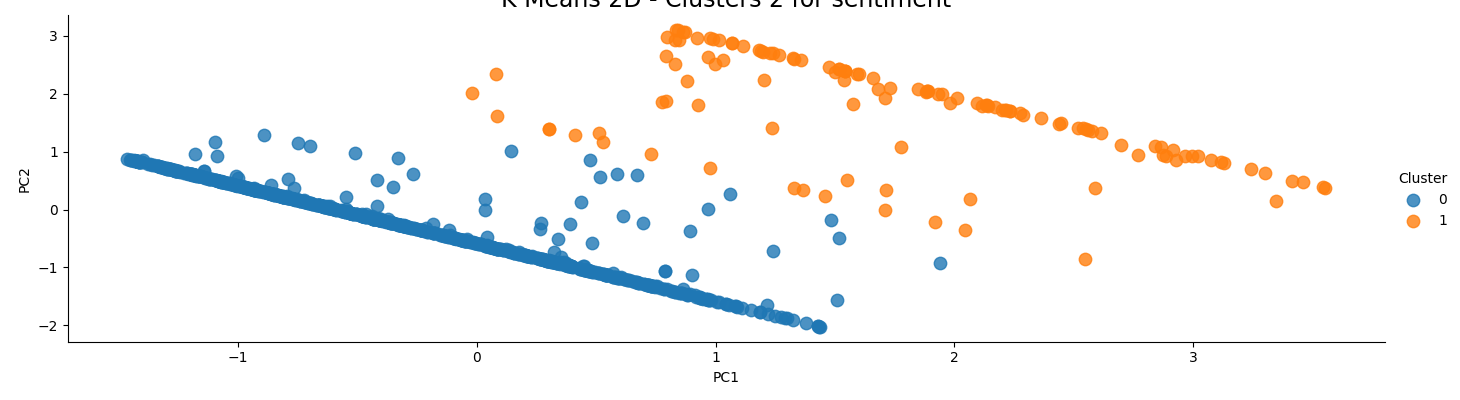

[]

In [99]:
#sentiments
%matplotlib notebook

s_pca_2D = decomposition.PCA(n_components=2, random_state=42)
s_pca_3D = decomposition.PCA(n_components=3, random_state=42)

s_pc_2D = s_pca_2D.fit_transform(X_scaled_sentiment.drop(['artists','song_name'], axis=1))


s_df_pca_2D_k1 = pd.DataFrame(data=s_pc_2D, columns=['PC1', 'PC2'])
s_df_pca_2D_k1['Cluster'] = sentiment_X_preds_k1

s_df_pca_2D_k2 = pd.DataFrame(data=s_pc_2D, columns=['PC1', 'PC2'])
s_df_pca_2D_k2['Cluster'] = sentiment_X_preds_k2

sns.lmplot(x='PC1', y='PC2', data=s_df_pca_2D_k1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {} for sentiment".format(k1_nclusters), fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=s_df_pca_2D_k2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {} for sentiment".format(k2_nclusters), fontsize=17)
plt.plot()

En este caso pareciera haber dos grupos separados en el espacio, que fueron encontrados por PCA.

## Analisis  de clústeres hechos con sentiment

Primero veamos cómo se comporta Kmeans con n_clusters=4

In [100]:
#sentiments
sent_song_clusters_k1['artists'] = sent_song_clusters_k1['artists'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True)
s_cluster_1 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 1]
s_cluster_2 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 2]
s_cluster_3 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 3]
s_cluster_4 = sent_song_clusters_k1[sent_song_clusters_k1["cluster"] == 0]

s_clusters = [s_cluster_1,s_cluster_2,s_cluster_3,s_cluster_4]
i = 1
for clus in s_clusters:
    print(f'El cluster {i} tiene {len(clus)} elementos')
    i += 1


El cluster 1 tiene 118 elementos
El cluster 2 tiene 285 elementos
El cluster 3 tiene 239 elementos
El cluster 4 tiene 278 elementos


In [101]:
df_s = sent_song_clusters_k1.copy()
extended_artists = ["Luis Miguel","Chayanne", 'La Oreja de Van Gogh',"Los Piojos","Arca", "Hermetica","Almafuerte", 
           "WOS", "Árbol","Rodrigo", "Damas Gratis", "Mala Fama", "La Mona Jimenez",
          "La Barra", "Raphael",'Andrés Calamaro','Pappo','Callejeros','Daddy Yankee','Calle 13']

df_s_by_artist = df_s.set_index('artists')
sent_dists = distrs_of_clusters_by_artists(artists_list=extended_artists,df=df_s_by_artist)

In [86]:
len(extended_artists)

20

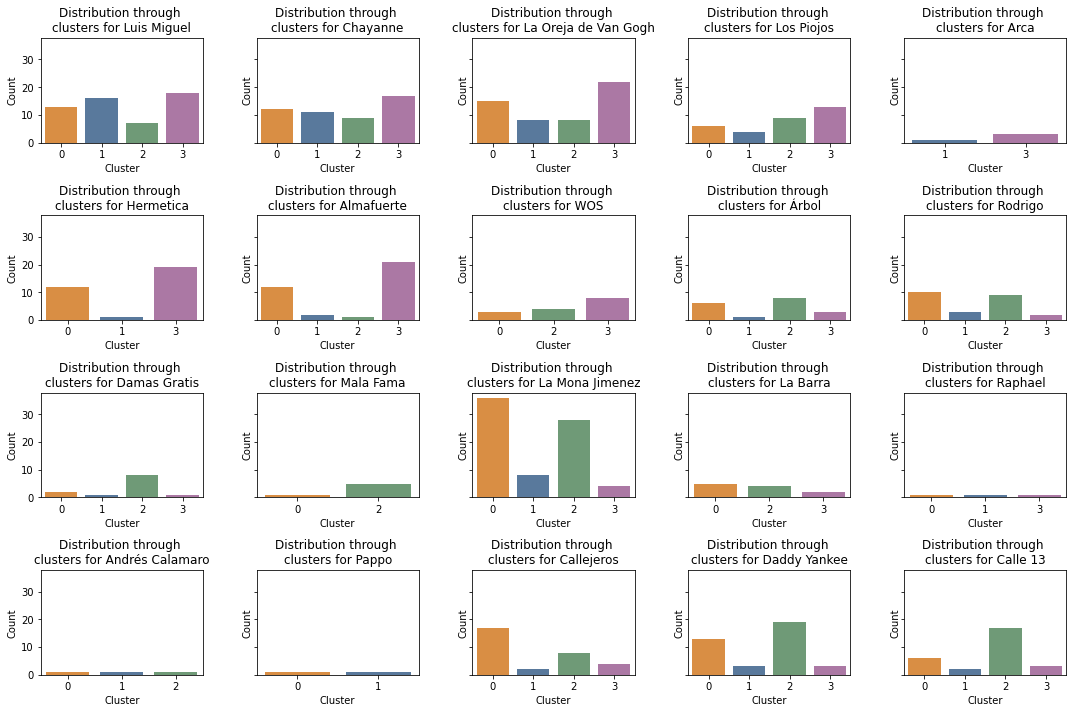

In [102]:
%matplotlib inline
def plot_distrs_of_clusters():
    i=0
    colors = {0: "#F28E2B", 1: "#4E79A7", 2: "#68a172", 3: "#b370aa"}
    fig, axs = plt.subplots(4, 5, figsize=(15,10), sharey=True)
    for j in range(4):
        for k in range(5):
            try:
                values = sent_dists[i].cluster.value_counts().index
                counts = sent_dists[i].cluster.value_counts()
            except:
                break
            sns.barplot(x=values,y=counts,ax=axs[j,k],palette=colors)
            axs[j,k].set_title(f'Distribution through \nclusters for {extended_artists[i]}')
            i+=1
        

    for ax in axs.flat:
        ax.set(xlabel='Cluster', ylabel='Count')
    #to plot uneven amount of subplots
    #fig.delaxes(axs[3,3])
    #fig.delaxes(axs[3,4])
    #fig.delaxes(axs[3,5])
    fig.tight_layout(pad=1.05)
    plt.show()

plot_distrs_of_clusters()

#### Observaciones
Las gráficas comparten la escala en el eje Y para poder comparar visualmente la performance del clustering.

Veamos primero los casos más extremos y sobrerrepresentados en el dataset.

Podemos ver ciertas cosas que uno espera encontrar:
- **Luis Miguel** y **Chayanne** tienen una distribución parecida entre ellos: la mayoría de sus canciones pertenecen al **cluster 3, 1 ó 0**, están bastante bien distribuidas en el resto de los clusteres
- **Almafuerte** y **Hermética** tienen una distribución parecida entre ellos: la mayoría de sus canciones pertenecen al **cluster 3, o en segunda instancia al cluster 0**. Prácticamente no tienen canciones pertenecientes al resto de los clústeres, en comparación.
- **Calle 13** y **Daddy Yankee** también: sus canciones pertenecen principalmente al **cluster 2**, y en segunda instancia y en menor medida, pero todavía considerablemente, al **cluster 0**.

Otras situaciones sorprenden:
- **Árbol** y **Rodrigo** tienen casi la misma distribución. En este caso, podemos ver que este clustering excede lo que se entiende como "género" musical, y probablemente hay otras causas latentes respecto a esta división.



Ante un análisis más minucioso pareceria ser que el clustering ante la presencia de 2 features, armó 4 posibles categorías, que corresponden a las permutaciones presentes en el dataset de estas dos características. En nuestro caso:
- Low lyrics_sentiment & Avg-to-High valence (**cluster 0**: letras "negativas", música neutral-a-eufórica)
- High lyrics_sentiment & High valence (**cluster 1**: emociones "positivas" tanto en letras como en música)
- Low-ish lyrics_sentiment, High valence valence (**cluster 2**: letras "negativas"-a-neutrales, música "positiva" -probablemente energética/eufórica/ )
- Low lyrics_sentiment,  Low-ish valence (**cluster 3**: emociones "negativas" tanto en letras como en música)

O sea las permutaciones posibles de estas features (A B, not-A B, A not-B, not-A not-B)

Esto puede servir para sirve para entender las distribuciones afectivas de las canciones de los artistas del dataset, e identificar las tendencias afectivas que podrían llegar a explicar la idea detrás de géneros.

Para ver esta división tomamos bandas que tienen valores a lo largo de todos los clústeres y vimos los valores medios (*mean*) de c/cluster.

In [103]:
clusters_sent = [s_cluster_4, s_cluster_1,s_cluster_2, s_cluster_3]
def compare_across_clusters_sent(*,clusters=clusters_sent, artist='La Oreja de Van Gogh'):
    s = []
    i=0
    print(f'Comparision between clusters for artist: {artist}')
    for cluster in clusters:
        s.append(pd.merge(X_unscaled, cluster, how='inner', on=['song_name']))
        data = s[i][s[i]['artists_y']==artist][['lyrics_sentiment_x','valence_x']].mean()
        print("Cluster ", i , " has: lyrics_sentiment: ",round(data.lyrics_sentiment_x,4), " || valence: ", round(data.valence_x,4))
        i+=1
        
compare_across_clusters_sent()

Comparision between clusters for artist: La Oreja de Van Gogh
Cluster  0  has: lyrics_sentiment:  0.0181  || valence:  0.5434
Cluster  1  has: lyrics_sentiment:  0.8489  || valence:  0.5274
Cluster  2  has: lyrics_sentiment:  0.0317  || valence:  0.7968
Cluster  3  has: lyrics_sentiment:  0.0018  || valence:  0.31


In [213]:
compare_across_clusters_sent(artist='La Mona Jimenez')

Comparision between clusters for artist: La Mona Jimenez
Cluster  0  has: lyrics_sentiment:  0.0103  || valence:  0.6164
Cluster  1  has: lyrics_sentiment:  0.8793  || valence:  0.6431
Cluster  2  has: lyrics_sentiment:  0.0016  || valence:  0.8072
Cluster  3  has: lyrics_sentiment:  0.0001  || valence:  0.3546


In [126]:
def compare_across_clusters_all_artists_sent(*,clusters=clusters_sent):
    s = []
    i=0
    print(f'Comparision between clusters for all artists')
    for cluster in clusters:
        s.append(pd.merge(X_unscaled, cluster, how='inner', on=['song_name']))
        data = s[i].mean()
        if not np.isnan(data.lyrics_sentiment_x):
            print("⚫ Cluster ", i , " has:\nlyrics_sentiment: ",round(data.lyrics_sentiment_x,4), "|| valence: ", round(data.valence_x,4)             )
            #print(len(s[i]))
        i+=1

compare_across_clusters_all_artists_sent()

Comparision between clusters for all artists
⚫ Cluster  0  has:
lyrics_sentiment:  0.0135 || valence:  0.5989
⚫ Cluster  1  has:
lyrics_sentiment:  0.8979 || valence:  0.5977
⚫ Cluster  2  has:
lyrics_sentiment:  0.0153 || valence:  0.8292
⚫ Cluster  3  has:
lyrics_sentiment:  0.0233 || valence:  0.3252


Ahora veamos cómo se comporta Kmeans con **n_clusters=2**

In [104]:
#sentiments
sent_song_clusters_k2['artists'] = sent_song_clusters_k2['artists'].apply(lambda x: pd.Series(x[0])).stack().reset_index(level=1, drop=True)
s_cluster_1_b = sent_song_clusters_k2[sent_song_clusters_k2["cluster"] == 0]
s_cluster_2_b = sent_song_clusters_k2[sent_song_clusters_k2["cluster"] == 1]

s_clusters_b = [s_cluster_1_b,s_cluster_2_b]
i = 1
for clus in s_clusters_b:
    print(f'El cluster {i} tiene {len(clus)} elementos')
    i += 1

El cluster 1 tiene 797 elementos
El cluster 2 tiene 123 elementos


In [105]:
df_s_b = sent_song_clusters_k2.copy()
extended_artists = ["Luis Miguel","Chayanne", 'La Oreja de Van Gogh',"Los Piojos","Arca", "Hermetica","Almafuerte", 
           "WOS", "Árbol","Rodrigo", "Damas Gratis", "Mala Fama", "La Mona Jimenez",
          "La Barra", "Raphael",'Andrés Calamaro','Pappo','Callejeros','Daddy Yankee','Calle 13']

df_s_by_artist_b = df_s_b.set_index('artists')
sent_dists_b = distrs_of_clusters_by_artists(artists_list=extended_artists,df=df_s_by_artist_b)

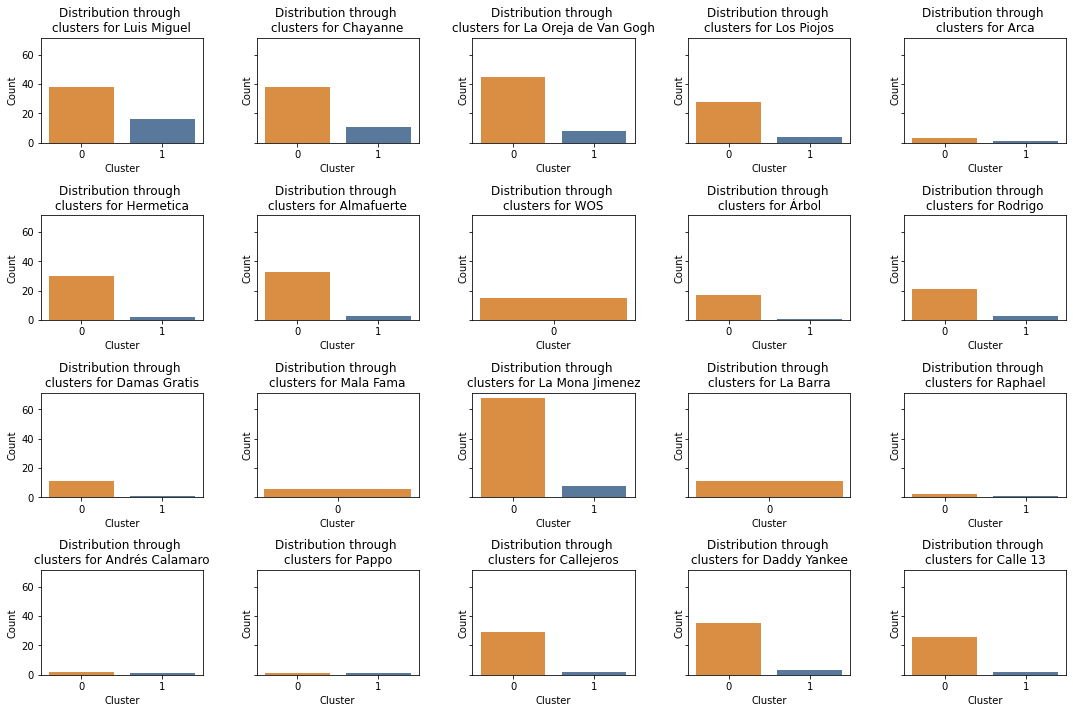

In [106]:
%matplotlib inline
def plot_distrs_of_clusters():
    i=0
    colors = {0: "#F28E2B", 1: "#4E79A7"}
    fig, axs = plt.subplots(4, 5, figsize=(15,10), sharey=True)
    for j in range(4):
        for k in range(5):
            try:
                values = sent_dists_b[i].cluster.value_counts().index
                counts = sent_dists_b[i].cluster.value_counts()
            except:
                break
            sns.barplot(x=values,y=counts,ax=axs[j,k], palette=colors)
            axs[j,k].set_title(f'Distribution through \nclusters for {extended_artists[i]}')
            i+=1
        

    for ax in axs.flat:
        ax.set(xlabel='Cluster', ylabel='Count')
    #fig.delaxes(axs[3,3])
    #fig.delaxes(axs[3,4])
    #fig.delaxes(axs[3,5])
    

#to plot uneven amount of subplots
#for i in range()
#    fig.delaxes(axs[0,4])
    fig.tight_layout(pad=1.05)
    plt.show()
plot_distrs_of_clusters()

#### Observaciones

Vemos que en este caso la división por género no fue relevante a la hora de armar estos clústers. Intentemos encontrar una posible causa latente de esta primera división.

In [123]:
s_cluster_1_b['artists'].value_counts()[:5]

La Mona Jimenez         68
La Oreja de Van Gogh    45
Luis Miguel             38
Chayanne                38
Daddy Yankee            35
Name: artists, dtype: int64

In [122]:
s_cluster_2_b['artists'].value_counts()[:5]

Luis Miguel             16
Chayanne                11
La Oreja de Van Gogh     8
La Mona Jimenez          8
Eruca Sativa             7
Name: artists, dtype: int64

In [108]:
clusters_sent_2=[s_cluster_1_b,s_cluster_2_b]
compare_across_clusters_sent(clusters=clusters_sent_2)

Comparision between clusters for artist: La Oreja de Van Gogh
Cluster  0  has: lyrics_sentiment:  0.0124  || valence:  0.4723
Cluster  1  has: lyrics_sentiment:  0.8489  || valence:  0.5274


In [110]:
compare_across_clusters_sent(clusters=clusters_sent_2, artist="La Mona Jimenez")

Comparision between clusters for artist: La Mona Jimenez
Cluster  0  has: lyrics_sentiment:  0.0064  || valence:  0.6702
Cluster  1  has: lyrics_sentiment:  0.8793  || valence:  0.6431


In [111]:
compare_across_clusters_sent(clusters=clusters_sent_2, artist="Luis Miguel")

Comparision between clusters for artist: Luis Miguel
Cluster  0  has: lyrics_sentiment:  0.0312  || valence:  0.4822
Cluster  1  has: lyrics_sentiment:  0.857  || valence:  0.5542


Viendo el comportamiento de las medias de los valores de cada clúster, podemos ver que este clustering separó las canciones "negativas" de las "positivas".

El **Cluster 0** contiene las canciones más "negativas" de cada artista, y el **Cluster 1** tiene las canciones más "positivas".

Esta división podría usarse como una forma de sintetizar el contenido de estas dos features en uno y reducir las dimensiones del dataset. O como un tag binario, que podría usarse como target para un clasificador, o para seguir analizando el dataset existente.